Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training SVR...
Processing GRU...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Processing Simple RNN...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Processing LSTM...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

Results:
                    Test R2  Test MSE
Linear Regression  0.886305  0.167556
Decision Tree      0.991762  0.012141
Random Forest      0.996746  0.004796
XGBoost            0.995650  0.006410
SVR                0.988855  0.016425
GRU                0.988278  0.017274
Simple RNN         0.982241  0.026172
LSTM               0.989449  0.015550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Actual Last Bitcoin Price: 84672
Predictions for Last Bitcoin Price:
Linear Regression: 68393.60
Decision Tree: 90999.17
Random Forest: 85945.74
XGBoost: 85484.35
SVR: 84440.51
GRU: 85081.18
Simple RNN: 80734.68
LSTM: 85997.17


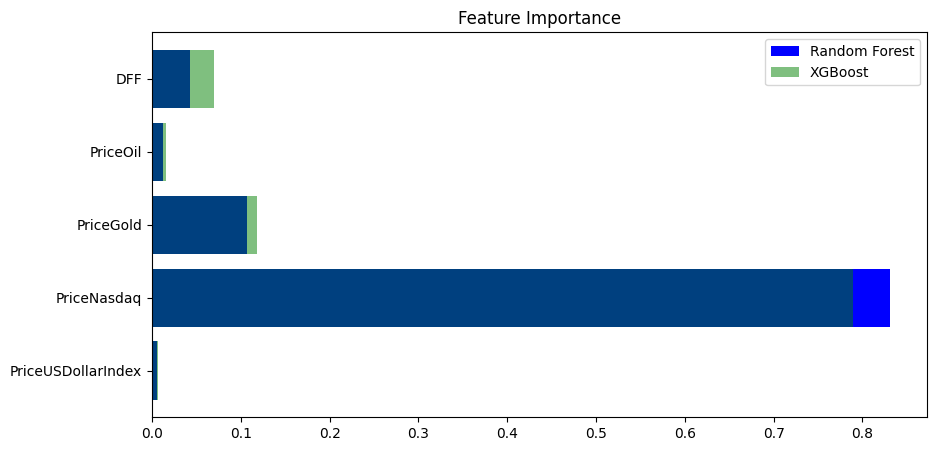

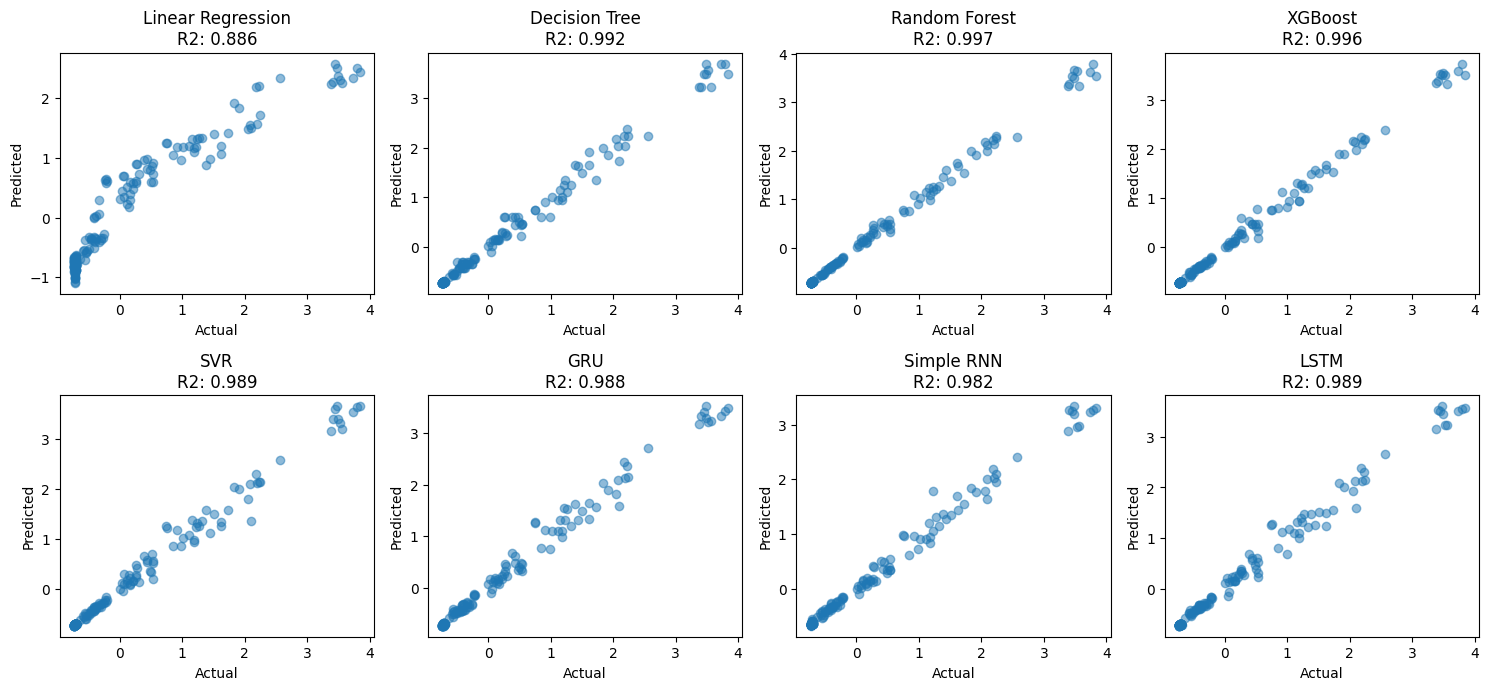

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dropout, Dense
import warnings

warnings.filterwarnings('ignore')

# --- 1. Load and preprocess data ---
df = pd.read_csv('/content/BTC_USD Bitfinextomorrownazdaq.csv')
df = df.dropna()

# ستون اول زمان است و حذف می‌شود
# ستون دوم متغیر وابسته (هدف) است
X = df.iloc[:, 2:]  # تمام ستون‌ها به جز اول و دوم
y = df.iloc[:, 1]   # ستون دوم به‌عنوان متغیر وابسته

# Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.05, random_state=0)

# Reshape data for RNN/GRU/LSTM models
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Dictionary to store results
results = {}
predictions_dict = {}

# --- 2. Define models and parameter grids ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR(),
}

param_grids = {
    "Linear Regression": {},
    "Decision Tree": {'max_depth': [3, 5, 7], 'min_samples_split': [5, 10, 20]},
    "Random Forest": {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [5, 10]},
    "XGBoost": {'n_estimators': [50, 100], 'max_depth': [3, 5],
                'learning_rate': [0.01, 0.05], 'reg_lambda': [0.1, 1], 'reg_alpha': [0, 0.1]},
    "SVR": {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5]},
}

# --- 3. Train models and evaluate performance ---
trained_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    trained_models[model_name] = grid.best_estimator_

    # Predictions on test set
    y_pred = grid.predict(X_test)
    predictions_dict[model_name] = y_pred

    # Store results
    results[model_name] = {
        'Test R2': r2_score(y_test, y_pred),
        'Test MSE': mean_squared_error(y_test, y_pred)
    }

# --- 4. Train GRU model ---
print("Processing GRU...")
def create_gru_model():
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

gru_model = create_gru_model()
history = gru_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
y_pred_gru = gru_model.predict(X_test_rnn).ravel()
predictions_dict['GRU'] = y_pred_gru
results['GRU'] = {
    'Test R2': r2_score(y_test, y_pred_gru),
    'Test MSE': mean_squared_error(y_test, y_pred_gru)
}
trained_models['GRU'] = gru_model

# --- 5. Train Simple RNN model ---
print("Processing Simple RNN...")
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

rnn_model = create_rnn_model()
history_rnn = rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
y_pred_rnn = rnn_model.predict(X_test_rnn).ravel()
predictions_dict['Simple RNN'] = y_pred_rnn
results['Simple RNN'] = {
    'Test R2': r2_score(y_test, y_pred_rnn),
    'Test MSE': mean_squared_error(y_test, y_pred_rnn)
}
trained_models['Simple RNN'] = rnn_model

# --- 6. Train LSTM model ---
print("Processing LSTM...")
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_rnn).ravel()
predictions_dict['LSTM'] = y_pred_lstm
results['LSTM'] = {
    'Test R2': r2_score(y_test, y_pred_lstm),
    'Test MSE': mean_squared_error(y_test, y_pred_lstm)
}
trained_models['LSTM'] = lstm_model

# --- 7. Display results ---
results_df = pd.DataFrame(results).T
print("\nResults:")
print(results_df)

# --- 8. Predict the last Bitcoin price ---
last_row = df.tail(1)  # Last row of the dataset
last_X = last_row.iloc[:, 2:]  # تمام ستون‌ها به جز اول و دوم
last_X_scaled = scaler_X.transform(last_X)

# Actual last Bitcoin price
actual_last_price = last_row.iloc[0, 1]  # ستون دوم به‌عنوان قیمت واقعی

# Predictions with all models
predictions = {}
for model_name in trained_models.keys():
    if model_name in ["GRU", "Simple RNN", "LSTM"]:
        last_X_scaled_rnn = last_X_scaled.reshape((1, 1, last_X_scaled.shape[1]))
        pred = trained_models[model_name].predict(last_X_scaled_rnn).ravel()[0]
    else:
        pred = trained_models[model_name].predict(last_X_scaled)[0]

    # معکوس استانداردسازی خروجی
    predicted_price = scaler_y.inverse_transform([[pred]])[0][0]
    predictions[model_name] = predicted_price

# Display predictions
print("\nActual Last Bitcoin Price:", actual_last_price)
print("Predictions for Last Bitcoin Price:")
for model_name, pred in predictions.items():
    print(f"{model_name}: {pred:.2f}")

# --- 9. Feature importance ---
rf_feature_importance = trained_models["Random Forest"].feature_importances_
xgb_feature_importance = trained_models["XGBoost"].feature_importances_

feature_names = X.columns  # نام ستون‌های متغیرهای توضیحی
plt.figure(figsize=(10, 5))
plt.barh(feature_names, rf_feature_importance, color='blue', label='Random Forest')
plt.barh(feature_names, xgb_feature_importance, color='green', alpha=0.5, label='XGBoost')
plt.title('Feature Importance')
plt.legend()
plt.show()

# --- 10. Scatter plots for actual vs predicted values ---
plt.figure(figsize=(15, 10))
for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
    plt.subplot(3, 4, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title(f'{model_name}\nR2: {r2_score(y_test, y_pred):.3f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()